# LGBM을 활용한 베이스라인

In [14]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import os
import random
import warnings
warnings.filterwarnings('ignore')
base_feats = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum']

## 1. 데이터 로딩
data_dir = '/opt/ml/input/data' # 경로
train_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터
test_file_path = os.path.join(data_dir, 'test_data.csv')
df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)
df_test = df_test[df_test.answerCode!=-1]  # answer_code -1 제외
df_train.shape, df_test.shape
df = pd.read_csv(os.path.join(data_dir, 'train_test_last2.csv'))

((2266586, 6), (259370, 6))

## 2. Feature Engineering

In [15]:
day_dict = {'Tuesday': 0,
 'Thursday': 1,
 'Monday': 2,
 'Saturday': 3,
 'Friday': 4,
 'Wednesday': 5,
 'Sunday': 6}

In [16]:
def feature_engineering(df):
    df2 = df.copy()
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df2['user_correct_answer'] = df2.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df2['user_total_answer'] = df2.groupby('userID')['answerCode'].cumcount()
    df2['user_acc'] = df2['user_correct_answer']/df2['user_total_answer']
    df2['month'] = pd.to_datetime(df2.Timestamp).dt.month
    df2['day'] = pd.to_datetime(df2.Timestamp).dt.day
    df2['hour'] = pd.to_datetime(df2.Timestamp).dt.hour
    df2['dayname'] = pd.to_datetime(df2.Timestamp).dt.day_name().map(day_dict)
    df2['big_category'] = df2.testId.map(lambda x:x[2]).astype(int)
    df2['problem_num'] = df2.assessmentItemID.map(lambda x: int(x[-3:]))
    df2['mid_category'] = df2.testId.map(lambda x: int(x[-3:]))

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df2.groupby(['testId'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_t.columns = ["test_mean", "test_std", 'test_sum']
    correct_k = df2.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_std', 'tag_sum']

    df2 = pd.merge(df2, correct_t, on=['testId'], how="left")
    df2 = pd.merge(df2, correct_k, on=['KnowledgeTag'], how="left")
    
    return df2

train_fe = feature_engineering(df_train)
test_fe = feature_engineering(df_test)
train_fe.shape, test_fe.shape

((2266586, 22), (259370, 22))

In [18]:
train_fe[:2]
test_fe[:2]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,month,...,dayname,big_category,problem_num,mid_category,test_mean,test_std,test_sum,tag_mean,tag_std,tag_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,3,...,0,6,1,1,0.947683,0.222749,1268,0.955022,0.207410,637
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.0,3,...,0,6,2,1,0.947683,0.222749,1268,0.913187,0.281603,3040


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,month,...,dayname,big_category,problem_num,mid_category,test_mean,test_std,test_sum,tag_mean,tag_std,tag_sum
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,NaN,0,NaN,1,...,1,5,1,23,0.473214,0.5004,106,0.587097,0.493952,91
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,1.0,1,1.0,1,...,1,5,2,23,0.473214,0.5004,106,0.587097,0.493952,91


## 3. Train/Test 데이터 셋 분리

### 3.2 train/test Custom 분리

In [19]:
test_to_train = test_fe[test_fe['userID'] == test_fe['userID'].shift(-1)]
test_to_train.shape
train_all = pd.concat([train_fe,test_to_train])
valid = test_fe[test_fe['userID'] != test_fe['userID'].shift(-1)]

# X, y 값 분리
y_train_main = train_all['answerCode']
train_main = train_all.drop(['answerCode'], axis=1)

y_test_main = valid['answerCode']
test_main = valid.drop(['answerCode'], axis=1)

# shape 출력
train_main.shape, test_main.shape

(258626, 22)

((2525212, 21), (744, 21))

In [6]:
test_to_train = test_fe[test_fe['userID'] == test_fe['userID'].shift(-1)]
test_to_train.shape
train_all = pd.concat([train_fe,test_to_train])
valid = test_fe[test_fe['userID'] != test_fe['userID'].shift(-1)]

# X, y 값 분리
y_train_main = train_all['answerCode']
train_main = train_all.drop(['answerCode'], axis=1)

y_test_main = valid['answerCode']
test_main = valid.drop(['answerCode'], axis=1)

# shape 출력
train_main.shape, test_main.shape

(259370, 22)

((2525956, 21), (744, 21))

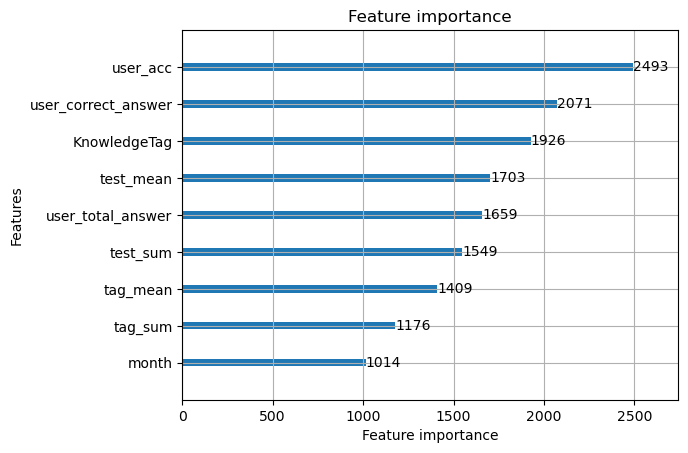

In [21]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 5. 기존 최대 성능

In [18]:
train_main.shape, test_main.shape

((2525212, 21), (744, 21))

In [7]:
train_main.shape, test_main.shape

((2525956, 21), (744, 21))

In [8]:
# 사용할 Feature 설정
FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std', 'tag_std',
         'tag_mean',
         'tag_sum',
        ]

In [9]:
train_main.shape

(2525956, 21)

In [10]:
test_main.shape

(744, 21)

In [11]:
lgb_train_main = lgb.Dataset(train_main[FEATS], y_train_main)
lgb_test_main = lgb.Dataset(test_main[FEATS], y_test_main)

model1 = lgb.train(
    {'objective': 'binary'}, 
    lgb_train_main,
    valid_sets=[lgb_test_main],
    verbose_eval=100,
    num_boost_round=3200,
#     early_stopping_rounds=200,
)

preds = model1.predict(test_main[FEATS])
acc = accuracy_score(y_test_main, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test_main, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1653588, number of negative: 872368
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 2525956, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654638 -> initscore=0.639491
[LightGBM] [Info] Start training from score 0.639491
[100]	valid_0's binary_logloss: 0.803649
[200]	valid_0's binary_logloss: 0.812115
[300]	valid_0's binary_logloss: 0.814919
[400]	valid_0's binary_logloss: 0.814489
[500]	valid_0's binary_logloss: 0.813104
[600]	valid_0's binary_logloss: 0.811175
[700]	valid_0's binary_logloss: 0.813467
[800]	valid_0's binary_logloss: 0.813273
[900]	valid_0's binary_logloss: 0.81649
[1000]	valid_0's binary_logloss: 0.818124
[1100]	valid_0's binary_lo

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [13]:
y_test_main

1035     -1
1706     -1
3023     -1
4283     -1
4670     -1
         ..
260052   -1
260067   -1
260082   -1
260097   -1
260113   -1
Name: answerCode, Length: 744, dtype: int64

In [19]:
lgb_train_main = lgb.Dataset(train_main[FEATS], y_train_main)
lgb_test_main = lgb.Dataset(test_main[FEATS], y_test_main)

model_e1 = lgb.train(
    {'objective': 'binary'}, 
    lgb_train_main,
    valid_sets=[lgb_test_main],
    verbose_eval=100,
    num_boost_round=3200,
#     early_stopping_rounds=200,
)

preds = model_e1.predict(test_main[FEATS])
acc = accuracy_score(y_test_main, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test_main, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1653175, number of negative: 872037
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 2525212, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654668 -> initscore=0.639621
[LightGBM] [Info] Start training from score 0.639621
[100]	valid_0's binary_logloss: 0.605976
[200]	valid_0's binary_logloss: 0.602041
[300]	valid_0's binary_logloss: 0.600447
[400]	valid_0's binary_logloss: 0.595921
[500]	valid_0's binary_logloss: 0.593755
[600]	valid_0's binary_logloss: 0.590534
[700]	valid_0's binary_logloss: 0.589904
[800]	valid_0's binary_logloss: 0.588589
[900]	valid_0's binary_logloss: 0.588649
[1000]	valid_0's binary_logloss: 0.588097
[1100]	valid_0's binary_l

In [20]:
lgb_train_main = lgb.Dataset(train_main[FEATS], y_train_main)
lgb_test_main = lgb.Dataset(test_main[FEATS], y_test_main)

model_e2 = lgb.train(
    {'objective': 'binary'}, 
    lgb_train_main,
    valid_sets=[lgb_test_main],
    verbose_eval=100,
    num_boost_round=10000,
    early_stopping_rounds=200,
)

preds = model_e2.predict(test_main[FEATS])
acc = accuracy_score(y_test_main, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test_main, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1653175, number of negative: 872037
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 2525212, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654668 -> initscore=0.639621
[LightGBM] [Info] Start training from score 0.639621
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.605976
[200]	valid_0's binary_logloss: 0.602041
[300]	valid_0's binary_logloss: 0.600447
[400]	valid_0's binary_logloss: 0.595921
[500]	valid_0's binary_logloss: 0.593755
[600]	valid_0's binary_logloss: 0.590534
[700]	valid_0's binary_logloss: 0.589904
[800]	valid_0's binary_logloss: 0.588589
[900]	valid_0's binary_logloss: 0.588649
[1000]	valid_0's binary_logloss: 0.588097
[1100]	valid_0's binary_log

### Inference

In [118]:
model3.params['num_iterations']

4800

In [27]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

test_df[:3]

# MAKE PREDICTION
total_preds = model_e2.predict(test_df[FEATS])

# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission_lgbm_cv_verification2.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    q=w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        q=w.write('{},{}\n'.format(id,p))

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,month,day,...,dayname,big_category,problem_num,mid_category,test_mean,test_std,test_sum,tag_mean,tag_std,tag_sum
1035,3,A050133008,A050000133,2020-10-26 13:13:57,5289,717.0,1035,0.692754,10,26,...,2,5,8,133,0.661765,0.490209,90,0.542662,0.505845,159
1706,4,A070146008,A070000146,2020-12-27 02:47:54,9080,465.0,670,0.694030,12,27,...,6,7,8,146,0.740385,0.539601,77,0.565693,0.552442,155
3023,13,A070111008,A070000111,2020-12-27 04:35:09,9660,915.0,1316,0.695289,12,27,...,6,7,8,111,0.417857,0.501291,117,0.446753,0.518307,172


writing prediction : output/submission_lgbm_cv_verification.csv


### 기존과 비교

In [28]:
df1 = pd.read_csv('output/submission_lgbm_add_time_test_tag_std_big_mid_problem_number_3200epoch_valauc_7718.csv')

In [29]:
df2 = pd.read_csv('output/submission_lgbm_cv_verification.csv')

In [35]:
dfm = df1.merge(df2,on='id')

In [41]:
dfm['diff'] = abs(dfm.prediction_x - dfm.prediction_y)

In [47]:
dfm['diff'].describe().reset_index().T

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
diff,744.0,0.08995,0.074653,0.000055,0.034,0.070803,0.12779,0.384599


## StratifiedKFold

In [21]:
from sklearn.model_selection import StratifiedGroupKFold

In [22]:
n_splits = 6
cv = StratifiedGroupKFold(n_splits=n_splits)

x = df.drop('answerCode',axis=1)
y = df['answerCode']

## 4. train
# 파라미터 설정
params = {
    # "max_depth": args.max_depth, # default=-1 (no limit)
#     "learning_rate": args.learning_rate,  # default = 0.1, [0.0005 ~ 0.5]
#     "boosting": "gbdt",
    "objective": "bianry"
#     "metric": args.metric,
#     "num_leaves": args.num_leaves,  # default = 31, [10, 20, 31, 40, 50]
#     "feature_fraction": args.feature_fraction,  # default = 1.0, [0.4, 0.6, 0.8, 1.0]
#     "bagging_fraction": args.bagging_fraction,  # default = 1.0, [0.4, 0.6, 0.8, 1.0]
#     "bagging_freq": args.bagging_freq,  # default = 0, [0, 1, 2, 3, 4]
#     "seed": 42,
#     "verbose": -1,
}

In [23]:
k_auc_list = list()
for k, (train_idx, valid_idx) in enumerate(cv.split(x,y,df.group),1):

    # train 분리
    train = x.iloc[train_idx]
    y_train = y.iloc[train_idx]

    # valid 분리
    val = x.iloc[valid_idx]
    valid = val[val.valid==1]
    y_valid = y.iloc[valid.index]

    lgb_train = lgb.Dataset(train[FEATS], y_train)
    lgb_valid = lgb.Dataset(valid[FEATS], y_valid)
    
    model_k1 = lgb.train(
        {'objective': 'binary'}, 
        lgb_train,
        valid_sets=[lgb_valid],
        verbose_eval=100,
        num_boost_round=3200,
    #     early_stopping_rounds=200,
    )

    preds = model_k1.predict(valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    k_auc_list.append(auc)
    print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1351413, number of negative: 720572
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 2071985, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.652231 -> initscore=0.628861
[LightGBM] [Info] Start training from score 0.628861
[100]	valid_0's binary_logloss: 0.638007
[200]	valid_0's binary_logloss: 0.63296
[300]	valid_0's binary_logloss: 0.632993
[400]	valid_0's binary_logloss: 0.632994
[500]	valid_0's binary_logloss: 0.630552
[600]	valid_0's binary_logloss: 0.629557
[700]	valid_0's binary_logloss: 0.628693
[800]	valid_0's binary_logloss: 0.629121
[900]	valid_0's binary_logloss: 0.628516
[1000]	valid_0's binary_logloss: 0.629717
[1100]	valid_0's binary_lo

[100]	valid_0's binary_logloss: 0.635052
[200]	valid_0's binary_logloss: 0.631489
[300]	valid_0's binary_logloss: 0.630766
[400]	valid_0's binary_logloss: 0.629144
[500]	valid_0's binary_logloss: 0.628162
[600]	valid_0's binary_logloss: 0.625932
[700]	valid_0's binary_logloss: 0.627511
[800]	valid_0's binary_logloss: 0.628723
[900]	valid_0's binary_logloss: 0.63057
[1000]	valid_0's binary_logloss: 0.630895
[1100]	valid_0's binary_logloss: 0.631353
[1200]	valid_0's binary_logloss: 0.631419
[1300]	valid_0's binary_logloss: 0.630896
[1400]	valid_0's binary_logloss: 0.632055
[1500]	valid_0's binary_logloss: 0.63182
[1600]	valid_0's binary_logloss: 0.631605
[1700]	valid_0's binary_logloss: 0.631812
[1800]	valid_0's binary_logloss: 0.63188
[1900]	valid_0's binary_logloss: 0.630647
[2000]	valid_0's binary_logloss: 0.630152
[2100]	valid_0's binary_logloss: 0.630248
[2200]	valid_0's binary_logloss: 0.631572
[2300]	valid_0's binary_logloss: 0.632326
[2400]	valid_0's binary_logloss: 0.632254
[250

In [25]:
kfold_auc = sum(k_auc_list) / n_splits
kfold_auc

0.7183061288062406

In [24]:
k_auc_list2 = list()
for k, (train_idx, valid_idx) in enumerate(cv.split(x,y,df.group),1):

    # train 분리
    train = x.iloc[train_idx]
    y_train = y.iloc[train_idx]

    # valid 분리
    val = x.iloc[valid_idx]
    valid = val[val.valid==1]
    y_valid = y.iloc[valid.index]

    lgb_train = lgb.Dataset(train[FEATS], y_train)
    lgb_valid = lgb.Dataset(valid[FEATS], y_valid)
    
    model_k2 = lgb.train(
        {'objective': 'binary'}, 
        lgb_train,
        valid_sets=[lgb_valid],
        verbose_eval=100,
        num_boost_round=10000,
        early_stopping_rounds=200,
    )

    preds = model_k2.predict(valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    k_auc_list2.append(auc)
    print(f'VALID AUC : {auc} ACC : {acc}\n')

kfold_auc = sum(k_auc_list2) / n_splits

[LightGBM] [Info] Number of positive: 1351413, number of negative: 720572
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 2071985, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.652231 -> initscore=0.628861
[LightGBM] [Info] Start training from score 0.628861
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.638007
[200]	valid_0's binary_logloss: 0.63296
[300]	valid_0's binary_logloss: 0.632993
[400]	valid_0's binary_logloss: 0.632994
[500]	valid_0's binary_logloss: 0.630552
[600]	valid_0's binary_logloss: 0.629557
[700]	valid_0's binary_logloss: 0.628693
[800]	valid_0's binary_logloss: 0.629121
[900]	valid_0's binary_logloss: 0.628516
[1000]

In [26]:
kfold_auc2 = sum(k_auc_list2) / n_splits
kfold_auc2

0.7203746731314044

In [ ]:
for k, (train_idx, valid_idx) in enumerate(cv.split(x,y,df.group),1):

    # train 분리
    train = x.iloc[train_idx]
    y_train = y.iloc[train_idx]

    # valid 분리
    val = x.iloc[valid_idx]
    valid = val[val.valid==1]
    y_valid = y.iloc[valid.index]

    model2 = lgb.LGBMClassifier(
    **params,
    n_estimators=3200,
    silent=-1,
    )

    model.fit(
        X=train[FEATS],
        y=y_train,
        early_stopping_rounds=100,
        eval_set=[(train[FEATS], y_train), (valid[FEATS], y_valid)],
        eval_names=["train", "valid"],
        eval_metric="roc_auc",
#         verbose=100,
    )

    preds = model.predict_proba(valid[FEATS])[:, 1]
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    k_auc_list.append(auc)
    print(f'VALID AUC : {auc} ACC : {acc}\n')

kfold_auc = sum(k_auc_list) / n_splits